# Previsão de valor do Biticoin
### Proposta do projeto

Com a alta das criptomoedas, ter o auxilio de uma machine learning para ajudar nas decisões do dia a dia é uma ótima opção. Pensando nisso, nós criamos o modelo abaixo para efetuar a previsão do valor do bitcoin.

### Coleta de dados

Para efetuar a previsão, o primeiro passo é alimentar o nosso sistema com dados, para isto iremos utilizar a api `CoinGecko` que nos fornece dados da abertura e fechamento do valor diário do Biticoin. Iremos tambem utilizar as seguintes bibliotecas do python 
- `requests` -> para efetuar as requisições na api;
- `pandas` -> utilizado para organização e manipulação dos dados;
- `matplotlib.pyplot` -> para efetuar a exibição de gráficos;

#### Requisição para API

A função `fetch_biticoin_data` é a responsável por fazer a requisição para API, para isto recebemos o numero de dias que desejamos consultar os dados, caso o numero de dias não seja passado, utilizamos 90 dias.

In [21]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_bitcoin_data(days=90):
    # Configurações da API da CoinGecko
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': str(days)
    }

    # Fazer requisição para a API
    response = requests.get(url, params=params)
    data = response.json()

    # Verificar se os dados foram retornados corretamente
    if 'prices' in data:
        # Criar DataFrame com os preços
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Reordenar colunas
        df = df[['close']]
        return df
    else:
        print("Erro ao obter dados:", data)
        return None

# Coletar dados
df = fetch_bitcoin_data(30)

### Agregação dos Dados Diários
Agrupamos os dados para obter o preço médio e o preço de fechamento diário.

In [22]:
# Agregar dados para obter o preço médio e final diário
df_daily = df.resample('D').agg({'close': ['mean', 'last']})
df_daily.columns = ['mean_price', 'final_price']  # Renomear colunas

### Visualização dos Dados
Exibimos os primeiros dados agregados e plotamos um gráfico dos preços.
- O gráfico exibe a evolução do preço médio e do preço de fechamento do Bitcoin ao longo dos dias.

              mean_price   final_price
timestamp                             
2024-10-31  71521.593458  70405.275607
2024-11-01  69674.689617  69544.596503
2024-11-02  69500.848090  69258.747373
2024-11-03  68517.334442  68910.256350
2024-11-04  68465.565697  67826.135956


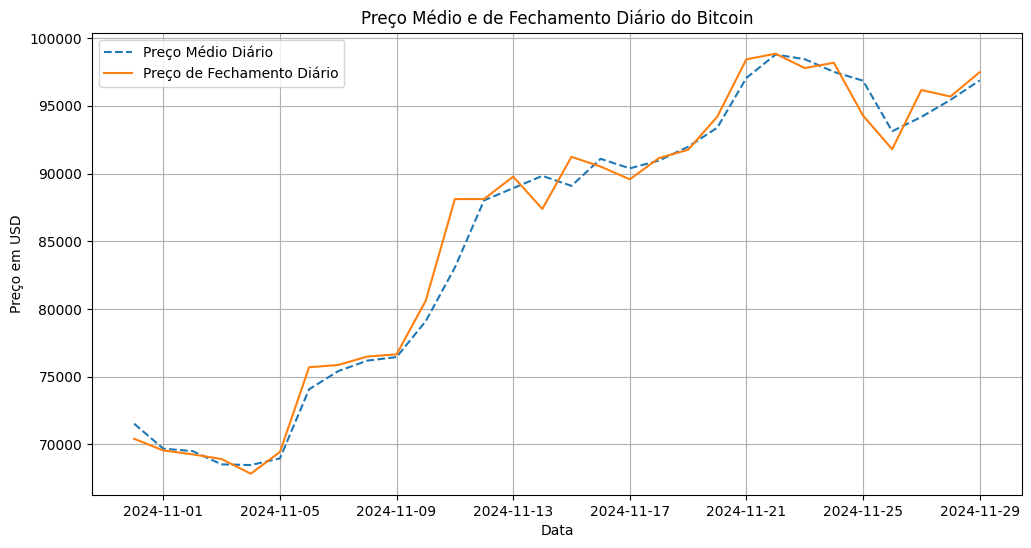

In [23]:
print(df_daily.head())

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['mean_price'], label='Preço Médio Diário', linestyle='--')
plt.plot(df_daily.index, df_daily['final_price'], label='Preço de Fechamento Diário', linestyle='-')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.title('Preço Médio e de Fechamento Diário do Bitcoin')
plt.legend()
plt.grid(True)
plt.show()

### Adição de Novas Variáveis Derivadas
Criamos uma função para adicionar novas features ao nosso conjunto de dados.

- rolling_mean: Média móvel dos últimos 7 dias.
- volatility: Desvio padrão dos últimos 7 dias, representando a volatilidade.
- dropna(): Remove linhas com valores nulos resultantes das operações de janela.

In [24]:

# Função para adicionar novas variáveis derivadas
def add_features(df):
    df['rolling_mean'] = df['close'].rolling(window=7).mean()  # Média móvel de 7 dias
    df['volatility'] = df['close'].rolling(window=7).std()    # Volatilidade
    df = df.dropna()  # Remover valores nulos gerados pelas janelas
    return df

# Aplicando engenharia de features
feature_data = add_features(df)
print("Novas features adicionadas:")
print(feature_data.head())


Novas features adicionadas:
                                close  rolling_mean  volatility
timestamp                                                      
2024-10-31 06:00:44.439  72266.098959  72310.966019  113.899400
2024-10-31 07:02:49.034  72203.029864  72284.410871  114.365087
2024-10-31 08:09:46.562  72329.489351  72290.618475  115.640194
2024-10-31 09:07:25.033  72321.146689  72307.631856  109.009076
2024-10-31 10:12:33.786  72295.049676  72275.557087   56.767907


### Normalização dos Dados
Utilizamos a classe MinMaxScaler para normalizar os dados entre 0 e 1.
- MinMaxScaler: Normaliza os dados para o intervalo especificado.
- Features Normalizadas: close, rolling_mean, volatility.

In [25]:

from sklearn.preprocessing import MinMaxScaler

# Função para normalizar dados
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['close', 'rolling_mean', 'volatility']].values)
    return scaled_data, scaler

scaled_data, scaler = normalize_data(feature_data)
print("Dados normalizados com sucesso!")


Dados normalizados com sucesso!


### Preparação do Conjunto de Dados para o Modelo LSTM
Criamos uma função para estruturar os dados no formato necessário para o LSTM.
- look_back: Número de dias anteriores usados para prever o próximo.
- Estrutura dos Dados:
  - X: Sequências de look_back dias de features.
  - Y: Preço de fechamento no dia seguinte.
- Divisão em Treino e Teste: 80% para treino e 20% para teste.

In [26]:
import numpy as np
from keras import Sequential
from keras.src.layers import LSTM, Dense, Dropout

# Função para criar conjuntos de dados
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])
        Y.append(data[i + look_back, 0])  # Prever o preço de fechamento
    return np.array(X), np.array(Y)

# Criando datasets
look_back = 30
X, Y = create_dataset(scaled_data, look_back)
X_train, Y_train = X[:int(len(X) * 0.8)], Y[:int(len(Y) * 0.8)]
X_test, Y_test = X[int(len(X) * 0.8):], Y[int(len(Y) * 0.8):]

### Construção e Treinamento do Modelo LSTM
Definimos uma função para construir e treinar o modelo LSTM.

- Arquitetura do Modelo:
  - Camada LSTM com 100 unidades e return_sequences=True.
  - Camada Dropout com taxa de 20% para evitar overfitting.
  - Segunda camada LSTM com 100 unidades.
  - Camada Dense final com 1 unidade para a previsão.
- Compilação do Modelo:
  - Otimizador: adam.
  - Função de perda: mean_squared_error.
- Treinamento:
  - Número de épocas: 50.
  - Tamanho do batch: 32.
  - Utiliza dados de validação para monitorar o desempenho.

In [27]:

# Construção e treinamento do modelo
def build_and_train_model(X_train, Y_train, X_test, Y_test, epochs=200, batch_size=32):
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=100),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
    return model, history

model, history = build_and_train_model(X_train, Y_train, X_test, Y_test)
print("Modelo treinado com sucesso!")


Epoch 1/200


c:\Users\diogoantonio\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1116 - val_loss: 0.0016
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

### Avaliação e Visualização do Modelo
Criamos uma função para avaliar o modelo e visualizar os resultados.

- Desnormalização das Previsões e Valores Reais:
  - Como apenas o primeiro atributo (preço de fechamento) foi previsto, concatenamos zeros para as outras features antes de aplicar a desnormalização.
- Métricas de Avaliação:
  - RMSE (Root Mean Squared Error): Raiz do erro quadrático médio.
  - MAE (Mean Absolute Error): Erro absoluto médio.
- Visualização:
  - Plotamos os valores reais e as previsões para comparar o desempenho do modelo.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
RMSE: 1081.7493433792592, MAE: 928.6345215599789


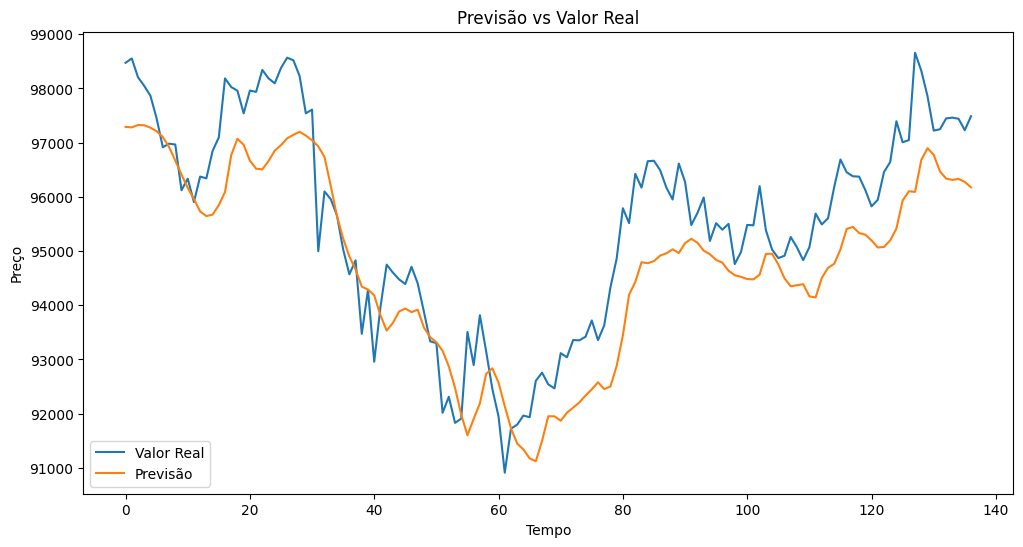

In [28]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Função para avaliar o modelo
def evaluate_and_visualize(model, X_test, Y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), 2))], axis=1))[:, 0]
    Y_test = scaler.inverse_transform(np.concatenate([Y_test.reshape(-1, 1), np.zeros((len(Y_test), 2))], axis=1))[:, 0]

    # Cálculo das métricas
    rmse = math.sqrt(mean_squared_error(Y_test, predictions))
    mae = mean_absolute_error(Y_test, predictions)
    print(f"RMSE: {rmse}, MAE: {mae}")

    # Visualização
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Valor Real')
    plt.plot(predictions, label='Previsão')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.title('Previsão vs Valor Real')
    plt.legend()
    plt.show()

# Avaliação e visualização
evaluate_and_visualize(model, X_test, Y_test, scaler)


### Resultado
Após executar o código, o modelo será treinado e avaliado. As métricas RMSE e MAE serão exibidas, e um gráfico comparativo entre os valores reais e previstos será apresentado.

In [29]:
# Prever o próximo valor do Bitcoin
def predict_next_value(model, data, scaler, look_back=30):
    # Selecionar os últimos `look_back` dias para a previsão
    last_data = data[-look_back:]
    last_data = last_data.reshape(1, look_back, data.shape[1])  # Formatar para o modelo LSTM
    
    # Fazer a previsão
    prediction = model.predict(last_data)
    
    # Desnormalizar a previsão
    prediction = scaler.inverse_transform(np.concatenate([prediction, np.zeros((1, data.shape[1] - 1))], axis=1))[0, 0]
    return prediction

# Previsão do próximo valor
next_value = predict_next_value(model, scaled_data, scaler)
print(f"O valor previsto do Bitcoin para o próximo momento é: ${next_value:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
O valor previsto do Bitcoin para o próximo momento é: $96213.47
